In [2]:
from __future__ import print_function,division 
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import poly1d

from collections import defaultdict
import itertools

#from brmbs.simulation.DataGenerator import generateSimulatedBDTPrice, callableBond, TestFunctionGenerator
from brmbs.model.OrthogonalRegression import *
import brmbs.data.DataLoader as dl
from brmbs.preprocessing.IssuanceProcessor import RegressionPeriod, get_coupon_periods
from brmbs.simulation.PolynomialSimulation import simulate_poly_fit

%matplotlib inline

C:\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Read Data

In [71]:
df, TBAs, params, all_coupons, rate_Base_raw, FN_issue, rate_Base = dl.load_all_data(data_folder = '../data/')
collapse_without_order, collapse_with_order = get_coupon_periods(df, all_coupons, FN_issue)

data = TBAs[4.5]['2010-01-01':]
prices = data.price.values
rates = data.MTGFNCL.values / 100

ret = (prices[1:] - prices[:-1]) / prices[:-1]
delta_r = rates[1:] - rates[:-1]

full_dates = data.index
ret_dates = data.index[1:]

# Two methods of calculation duration

### Method 1:

$$\frac{\Delta price}{price} = - duration_t * \Delta rate$$

### Method 2:

$$price = \alpha_t + \beta_t * rate$$

or

$$price = \alpha_t + \beta_t * rate + \gamma_t * rate^2$$

$$duration = -\frac{price(rate + \Delta r) - price(rate - \Delta r)}{2\Delta r * price}$$

# Duration from rolling window as benchmark

In [84]:
window_120 = 120
D_120 = []
for t in range(len(delta_r) - window_120):
    y = ret[t : t+window_120]
    x = delta_r[t : t+window_120]
    model = sm.OLS(y, x)
    result = model.fit()
    D_120.append(- result.params[0])

In [83]:
window_120 = 120
D2_120 = []
for t in range(len(rates) - window_120):
    y = prices[t : t+window_120]
    x = rates[t : t+window_120]
    model = sm.OLS(y, np.vstack((x, np.ones(len(x)))).T)
    result = model.fit()
    D2_120.append(- result.params[0] / y[-1])

In [115]:
window_120 = 120
Da2_120 = []
for t in range(len(rates) - window_120):
    y = prices[t : t+window_120]
    x = rates[t : t+window_120]
    model = sm.OLS(y, np.vstack((x**2, x, np.ones(len(x)))).T)
    result = model.fit()
    Da2_120.append(- (2 * result.params[0] * x[-1] + result.params[1]) / y[-1])

In [85]:
window_20 = 20
D_20 = []
for t in range(len(delta_r) - window_20):
    y = ret[t : t+window_20]
    x = delta_r[t : t+window_20]
    model = sm.OLS(y, x)
    result = model.fit()
    D_20.append(- result.params[0])

In [86]:
window_20 = 20
D2_20 = []
for t in range(len(rates) - window_20):
    y = prices[t : t+window_20]
    x = rates[t : t+window_20]
    model = sm.OLS(y, np.vstack((x, np.ones(len(x)))).T)
    result = model.fit()
    D2_20.append(- result.params[0] / y[-1])

In [117]:
window_20 = 20
Da2_20 = []
for t in range(len(rates) - window_20):
    y = prices[t : t+window_20]
    x = rates[t : t+window_20]
    model = sm.OLS(y, np.vstack((x**2, x, np.ones(len(x)))).T)
    result = model.fit()
    Da2_20.append(- (2 * result.params[0] * x[-1] + result.params[1]) / y[-1])

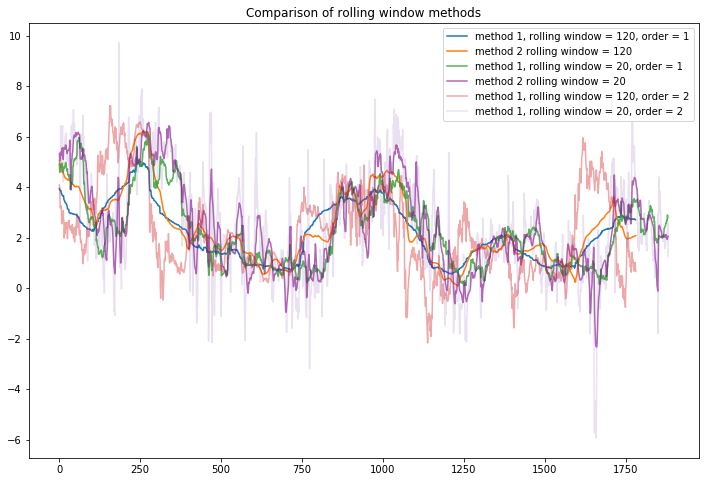

In [118]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.plot(D_120, label = 'method 1, rolling window = 120, order = 1')
ax.plot(D2_120, label = 'method 2 rolling window = 120')
ax.plot(D_20, label = 'method 1, rolling window = 20, order = 1', alpha = 0.8)
ax.plot(D2_20, label = 'method 2 rolling window = 20', c = 'purple', alpha = 0.6)
ax.plot(Da2_120, label = 'method 1, rolling window = 120, order = 2', alpha = 0.4)
ax.plot(Da2_20, label = 'method 1, rolling window = 20, order = 2', alpha = 0.2)
ax.set_title('Comparison of rolling window methods')
ax.legend()

# Kalman Filter

In [135]:
def beta_from_kalman_filter(state_cov, obs_cov, trans_cov, ini_mean, y, X):
    dim = len(ini_mean)
    kf_r = KalmanFilter(n_dim_obs = 1, n_dim_state = dim,
              initial_state_mean = ini_mean,
              initial_state_covariance = state_cov,

              transition_matrices = np.eye(dim),
              observation_matrices = X,

              observation_covariance = obs_cov,
              transition_covariance = trans_cov)
    
    kf_r = kf_r.em(y)
    state_means_beta, _ = kf_r.filter(y)
    state_means_beta_smooth, _ = kf_r.smooth(y)
    
    return state_means_beta, state_means_beta_smooth

In [105]:
def kf_duration_by_poly_fit_test(test_list, ini_mean, Prices, Rates, Total_T, window):

    '''
    Run regression between price and rate, take derivative. duration = - derivative / price
    
    test_list = [(state_cov, obs_cov, trans_cov), ...]
    '''
    
    dur= {}
    dur_smooth = {}
    dim = len(ini_mean)
    
    #Prepare Observation matrix 
    
    rates_window = Rates[window:Total_T + window]
    
    if dim == 2:
        obs_mat_r = np.expand_dims(np.vstack((rates_window, np.ones(Total_T))).T, axis=1)
    else:
        obs_mat_r = np.expand_dims(np.vstack((rates_window**2, rates_window, np.ones(Total_T))).T, axis=1)
    
    delta_r = 0.001
    r_plus = rates_window + delta_r
    r_minus = rates_window - delta_r
    if dim == 2:
        x_plus = np.expand_dims(np.vstack((r_plus, np.ones(Total_T))).T, axis=1).squeeze()
        x_minus = np.expand_dims(np.vstack((r_minus, np.ones(Total_T))).T, axis=1).squeeze()
    else:
        x_plus = np.expand_dims(np.vstack((r_plus**2, r_plus, np.ones(Total_T))).T, axis=1).squeeze()
        x_minus = np.expand_dims(np.vstack((r_minus**2, r_minus, np.ones(Total_T))).T, axis=1).squeeze()
    
    #Getting duration from the Kalman Filter Model
    for test_case in test_list:
        print('runing for case : ', test_case)
        state_cov, obs_cov, trans_cov = test_case
        mean_beta, mean_beta_smooth = beta_from_kalman_filter(np.eye(dim) * state_cov,obs_cov,np.eye(dim) * trans_cov,ini_mean, Prices[window:Total_T + window], obs_mat_r)
        
        y_minus = np.sum(x_minus * mean_beta, axis = 1).squeeze()
        y_plus = np.sum(x_plus * mean_beta, axis = 1).squeeze()
        duration = - (y_plus - y_minus) / (2 * delta_r * Prices[:Total_T])
        y_minus_sm = np.sum(x_minus * mean_beta_smooth, axis = 1).squeeze()
        y_plus_sm = np.sum(x_plus * mean_beta_smooth, axis = 1).squeeze()
        duration_smooth = - (y_plus_sm - y_minus_sm) / (2 * delta_r * Prices[:Total_T])

        dur[test_case] = duration
        dur_smooth[test_case] = duration_smooth
        
    return dur, dur_smooth

In [136]:
def kf_duration_by_definition_test(test_list, ini_mean, ret, delta_r, Total_T, window):

    '''
    Run regression between return and change in rate. duration is the coefficient
    
    test_list = [(state_cov, obs_cov, trans_cov), ...]
    '''
    
    dur= {}
    dur_smooth = {}
    dim = len(ini_mean)
    
    delta_r_window = delta_r[window:Total_T + window]
    
    obs_mat_r = np.expand_dims(np.vstack((delta_r_window, np.ones(Total_T))).T, axis=1)
    
    #Getting duration from the Kalman Filter Model
    for test_case in test_list:
        print('runing for case : ', test_case)
        state_cov, obs_cov, trans_cov = test_case
        mean_beta, mean_beta_smooth = beta_from_kalman_filter(np.eye(dim) * state_cov,obs_cov,np.eye(dim) * trans_cov,ini_mean, ret[window:Total_T + window], obs_mat_r)
        
        duration = - mean_beta[:,0]
        duration_smooth =  - mean_beta_smooth[:,0]
        
        dur[test_case] = duration
        dur_smooth[test_case] = duration_smooth
        
    return dur, dur_smooth

## Kalman Filter for method 2: $price = \alpha_t + \beta_t * rate$

The transition covariance and initial mean need to be scaled, since here the state variable is $\beta = - duration * price$

In [137]:
ini_mean = [-D2_120[0] * prices[window_120], 0]
state_cov = np.array([1, 0.1, 10])
obs_cov = np.array([0.5, 1, 2])
trans_cov = np.array([1, 5, 10])

all_test_cases = list(itertools.product(state_cov, obs_cov, trans_cov))

Total_T = 1000
dur, dur_smooth = kf_duration_by_poly_fit_test(all_test_cases, ini_mean, prices, rates, Total_T, window_120)

runing for case :  (1.0, 0.5, 1)
runing for case :  (1.0, 0.5, 5)
runing for case :  (1.0, 0.5, 10)
runing for case :  (1.0, 1.0, 1)
runing for case :  (1.0, 1.0, 5)
runing for case :  (1.0, 1.0, 10)
runing for case :  (1.0, 2.0, 1)
runing for case :  (1.0, 2.0, 5)
runing for case :  (1.0, 2.0, 10)
runing for case :  (0.10000000000000001, 0.5, 1)
runing for case :  (0.10000000000000001, 0.5, 5)
runing for case :  (0.10000000000000001, 0.5, 10)
runing for case :  (0.10000000000000001, 1.0, 1)
runing for case :  (0.10000000000000001, 1.0, 5)
runing for case :  (0.10000000000000001, 1.0, 10)
runing for case :  (0.10000000000000001, 2.0, 1)
runing for case :  (0.10000000000000001, 2.0, 5)
runing for case :  (0.10000000000000001, 2.0, 10)
runing for case :  (10.0, 0.5, 1)
runing for case :  (10.0, 0.5, 5)
runing for case :  (10.0, 0.5, 10)
runing for case :  (10.0, 1.0, 1)
runing for case :  (10.0, 1.0, 5)
runing for case :  (10.0, 1.0, 10)
runing for case :  (10.0, 2.0, 1)
runing for case 

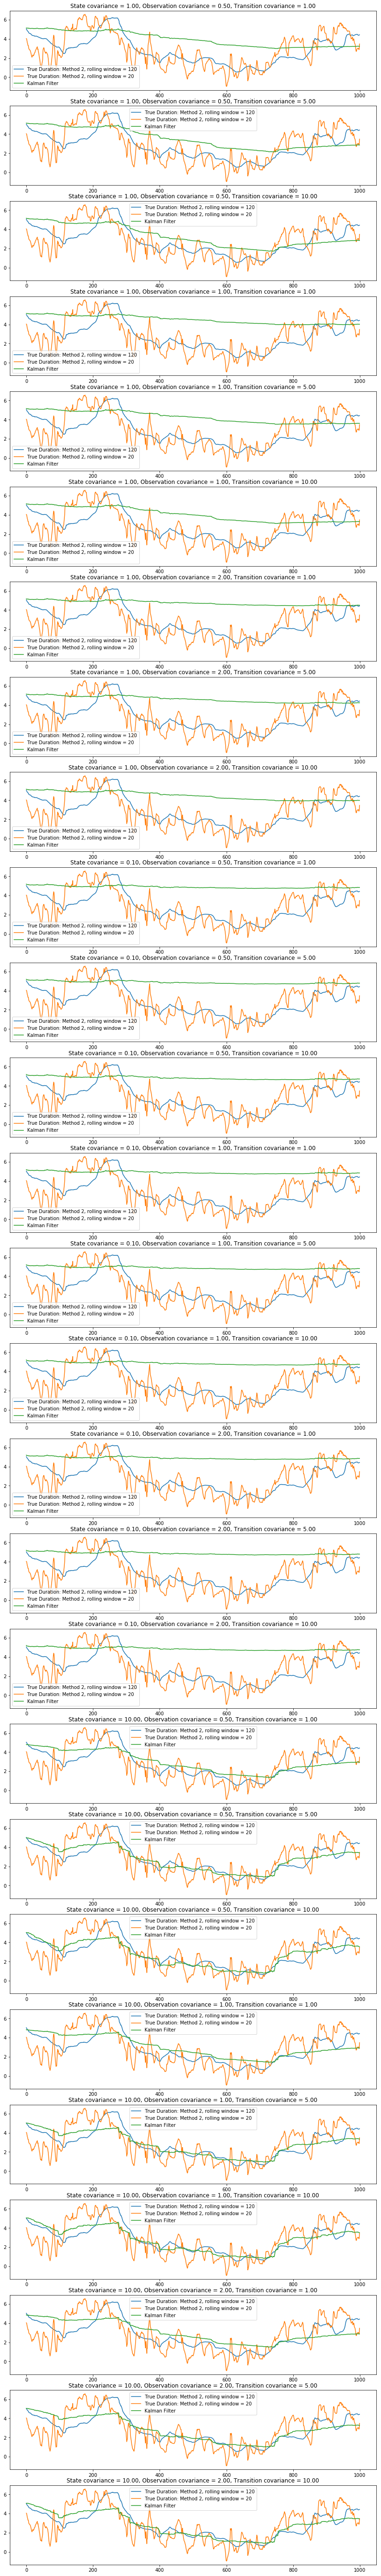

In [103]:
fig = plt.figure(figsize=(14,100))
size = len(all_test_cases)
for i, test_case in enumerate(all_test_cases, 1):
    single_dur = dur[test_case]
    ax = fig.add_subplot(size, 1, i)
    ax.plot(D2_120[:Total_T], label = 'True Duration: Method 2, rolling window = 120')
    ax.plot(D2_20[window_120 - window_20:Total_T + window_120 - window_20], label = 'True Duration: Method 2, rolling window = 20')
    ax.plot(single_dur, label = 'Kalman Filter')
    ax.legend()
    ax.set_title('State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(test_case[0], test_case[1], test_case[2]))

## Kalman Filter for method 2: $price = \alpha_t + \beta_t * rate + \gamma_t * rate^2$

In [124]:
ini_mean = [(-D2_120[0] * prices[window_120] - 50) / (2 * rates[window_120]), 50, 0]   # randomly picked  
state_cov = np.array([1, 0.1, 10])
obs_cov = np.array([0.5, 1, 2])
trans_cov = np.array([1, 5, 10])

all_test_cases = list(itertools.product(state_cov, obs_cov, trans_cov))

Total_T = 1000
dur, dur_smooth = kf_duration_by_poly_fit_test(all_test_cases, ini_mean, prices, rates, Total_T, window_120)

runing for case :  (1.0, 0.5, 1)
runing for case :  (1.0, 0.5, 5)
runing for case :  (1.0, 0.5, 10)
runing for case :  (1.0, 1.0, 1)
runing for case :  (1.0, 1.0, 5)
runing for case :  (1.0, 1.0, 10)
runing for case :  (1.0, 2.0, 1)
runing for case :  (1.0, 2.0, 5)
runing for case :  (1.0, 2.0, 10)
runing for case :  (0.10000000000000001, 0.5, 1)
runing for case :  (0.10000000000000001, 0.5, 5)
runing for case :  (0.10000000000000001, 0.5, 10)
runing for case :  (0.10000000000000001, 1.0, 1)
runing for case :  (0.10000000000000001, 1.0, 5)
runing for case :  (0.10000000000000001, 1.0, 10)
runing for case :  (0.10000000000000001, 2.0, 1)
runing for case :  (0.10000000000000001, 2.0, 5)
runing for case :  (0.10000000000000001, 2.0, 10)
runing for case :  (10.0, 0.5, 1)
runing for case :  (10.0, 0.5, 5)
runing for case :  (10.0, 0.5, 10)
runing for case :  (10.0, 1.0, 1)
runing for case :  (10.0, 1.0, 5)
runing for case :  (10.0, 1.0, 10)
runing for case :  (10.0, 2.0, 1)
runing for case 

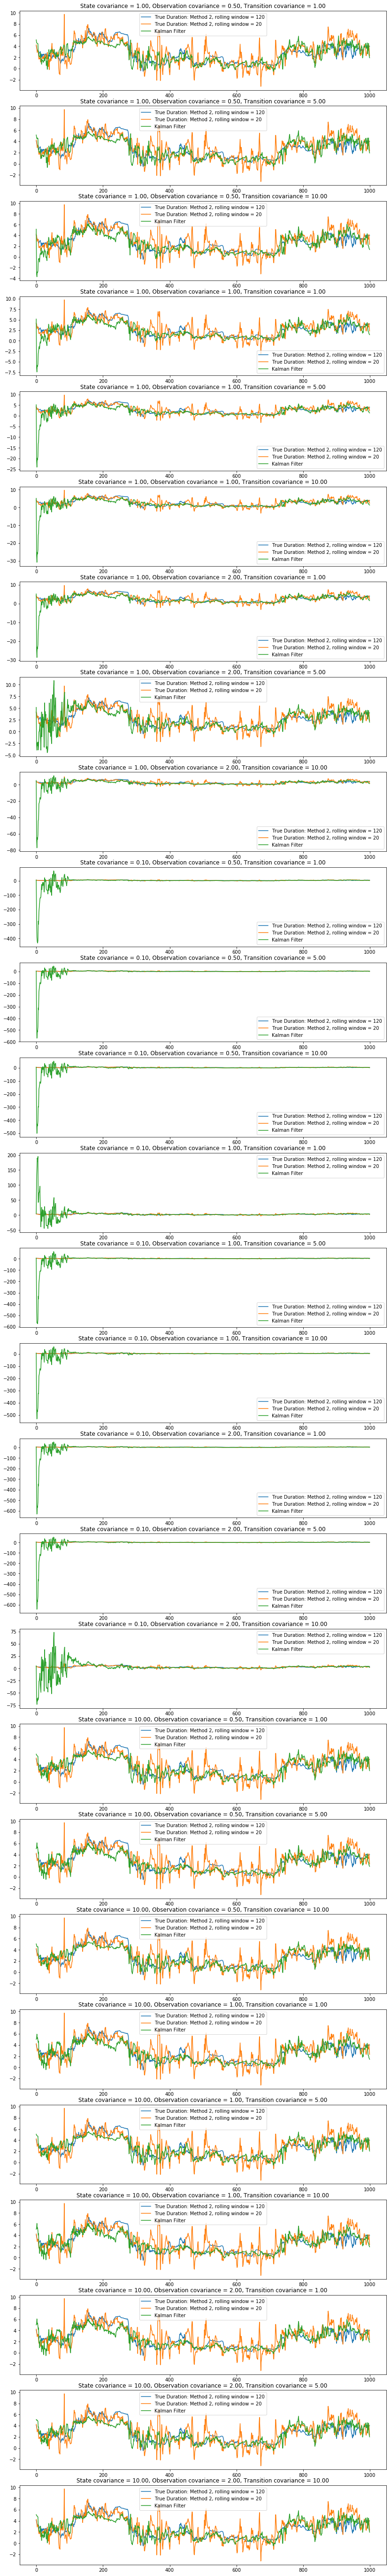

In [125]:
fig = plt.figure(figsize=(14,100))
size = len(all_test_cases)
for i, test_case in enumerate(all_test_cases, 1):
    single_dur = dur[test_case]
    ax = fig.add_subplot(size, 1, i)
    ax.plot(Da2_120[:Total_T], label = 'True Duration: Method 2, rolling window = 120')
    ax.plot(Da2_20[window_120 - window_20:Total_T + window_120 - window_20], label = 'True Duration: Method 2, rolling window = 20')
    ax.plot(single_dur, label = 'Kalman Filter')
    ax.legend()
    ax.set_title('State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(test_case[0], test_case[1], test_case[2]))

## Kalman Filter for method 1: $\frac{\Delta price}{price} = - duration_t * \Delta rate$

In [127]:
ini_mean = [-D_120[0],0]
state_cov = np.array([1, 0.1, 10])
obs_cov = np.array([0.5, 1, 2])
trans_cov = np.array([0.001, 0.01, 0.1])

all_test_cases = list(itertools.product(state_cov, obs_cov, trans_cov))

Total_T = 1000
dur, dur_smooth = kf_duration_by_definition_test(all_test_cases, ini_mean, ret, delta_r, Total_T, window_120)

runing for case :  (1.0, 0.5, 0.001)
runing for case :  (1.0, 0.5, 0.01)
runing for case :  (1.0, 0.5, 0.10000000000000001)
runing for case :  (1.0, 1.0, 0.001)
runing for case :  (1.0, 1.0, 0.01)
runing for case :  (1.0, 1.0, 0.10000000000000001)
runing for case :  (1.0, 2.0, 0.001)
runing for case :  (1.0, 2.0, 0.01)
runing for case :  (1.0, 2.0, 0.10000000000000001)
runing for case :  (0.10000000000000001, 0.5, 0.001)
runing for case :  (0.10000000000000001, 0.5, 0.01)
runing for case :  (0.10000000000000001, 0.5, 0.10000000000000001)
runing for case :  (0.10000000000000001, 1.0, 0.001)
runing for case :  (0.10000000000000001, 1.0, 0.01)
runing for case :  (0.10000000000000001, 1.0, 0.10000000000000001)
runing for case :  (0.10000000000000001, 2.0, 0.001)
runing for case :  (0.10000000000000001, 2.0, 0.01)
runing for case :  (0.10000000000000001, 2.0, 0.10000000000000001)
runing for case :  (10.0, 0.5, 0.001)
runing for case :  (10.0, 0.5, 0.01)
runing for case :  (10.0, 0.5, 0.1000

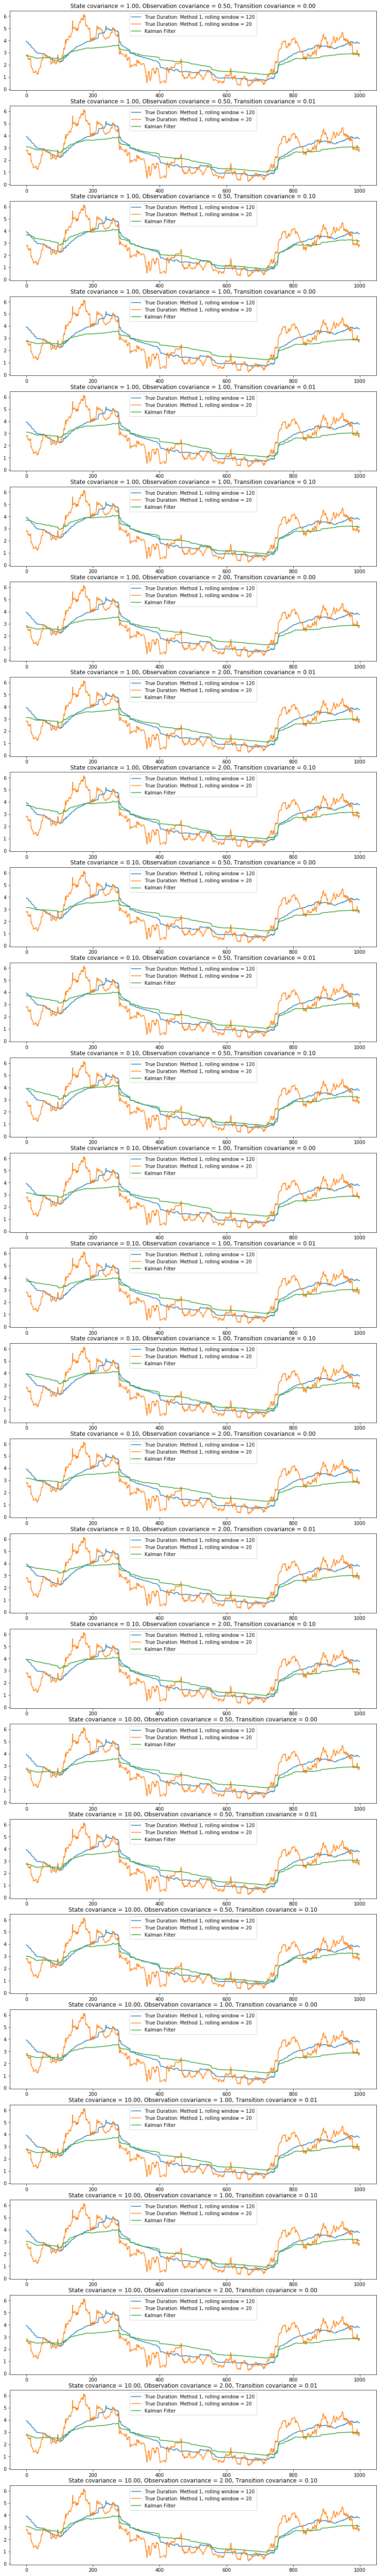

In [130]:
fig = plt.figure(figsize=(14,100))
size = len(all_test_cases)
for i, test_case in enumerate(all_test_cases, 1):
    single_dur = dur[test_case]
    ax = fig.add_subplot(size, 1, i)
    ax.plot(D_120[:Total_T], label = 'True Duration: Method 1, rolling window = 120')
    ax.plot(D_20[window_120 - window_20:Total_T + window_120 - window_20], label = 'True Duration: Method 1, rolling window = 20')
    ax.plot(single_dur, label = 'Kalman Filter')
    ax.legend()
    ax.set_title('State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(test_case[0], test_case[1], test_case[2]))